In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import cv2
import random
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Image completion
import os
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg



--2024-09-20 14:17:08--  https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg
Resolving segment-anything.com (segment-anything.com)... 54.230.18.11, 54.230.18.129, 54.230.18.18, ...
Connecting to segment-anything.com (segment-anything.com)|54.230.18.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 221810 (217K) [image/jpeg]
Saving to: 'dog.jpg'

dog.jpg             100%[===================>] 216.61K  --.-KB/s    in 0.04s   

2024-09-20 14:17:08 (5.75 MB/s) - 'dog.jpg' saved [221810/221810]



In [3]:
# Read in a image from torchvision
import torchvision
img = torchvision.io.read_image("dog.jpg")

print(img.shape)

torch.Size([3, 1365, 2048])


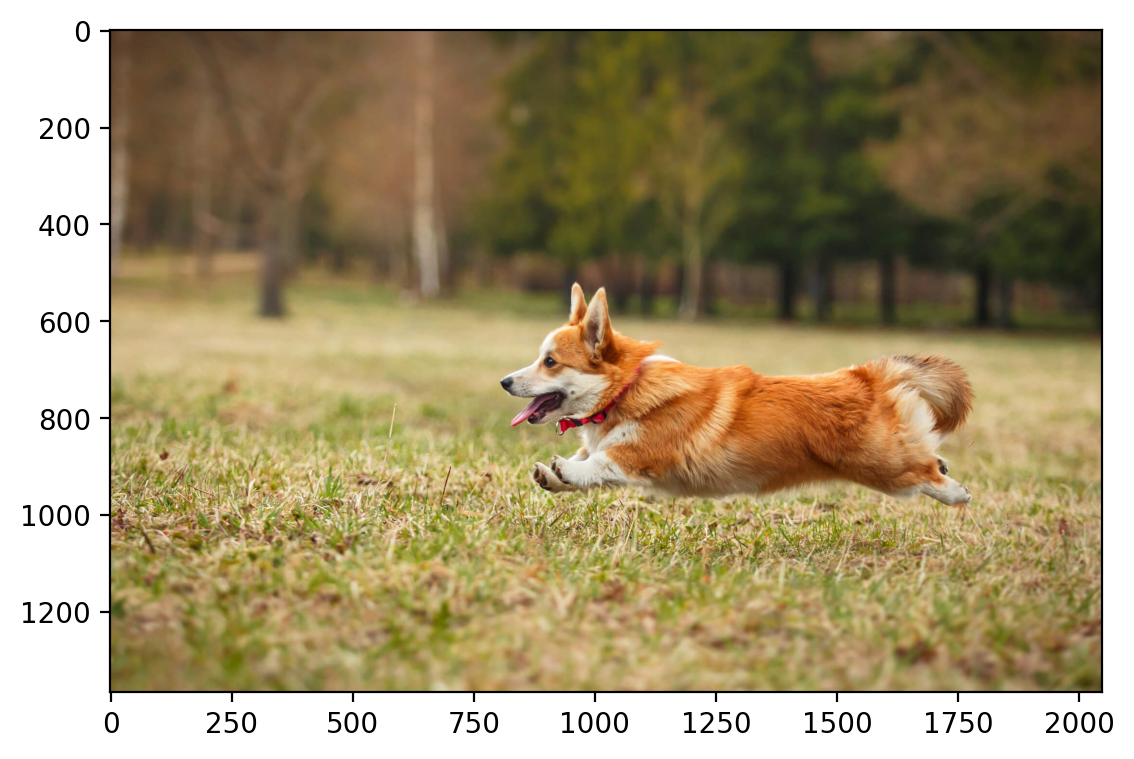

In [4]:
plt.imshow(rearrange(img, 'c h w -> h w c'))

In [5]:
crop = torchvision.transforms.functional.crop(img, 600, 800, 300, 300)
crop.shape

torch.Size([3, 300, 300])

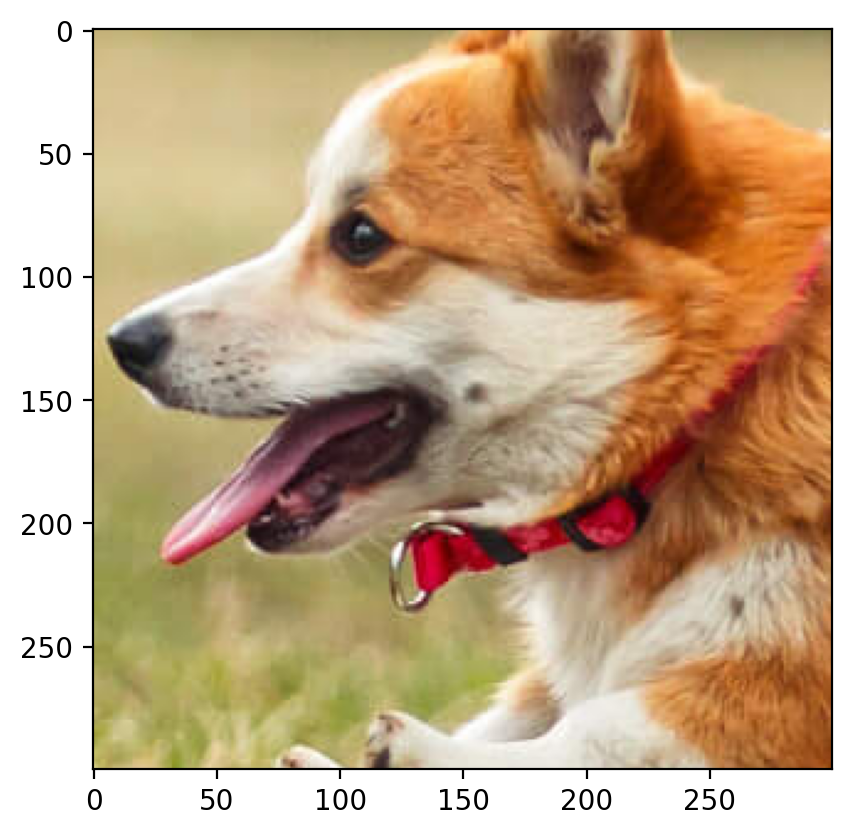

In [6]:
plt.imshow(rearrange(crop, 'c h w -> h w c'))

# Question 1

In [7]:
# Modify the loss function to ignore NaN values

def factorize(A, k, device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")):
    """Factorize the matrix D into A and B"""
    A = A.to(device)
    # Randomly initialize A and B
    W = torch.randn(A.shape[0], k, requires_grad=True, device=device)
    H = torch.randn(k, A.shape[1], requires_grad=True, device=device)
    # Optimizer
    optimizer = optim.Adam([W, H], lr=0.001)
    mask = ~torch.isnan(A)
    # Train the model
    for i in range(10000):
        # Compute the loss
        diff_matrix = torch.mm(W, H) - A
        diff_vector = diff_matrix[mask]
        loss = torch.norm(diff_vector)

        # Zero the gradients
        optimizer.zero_grad()

        # Backpropagate
        loss.backward()

        # Update the parameters
        optimizer.step()

    return W, H, loss

In [8]:
def plot_reconstructed_image(reconstructed_image, original):
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(rearrange(reconstructed_image, 'c h w -> h w c').cpu().numpy())
    ax0.set_title(f"Reconstructed Image")
    ax1.imshow(rearrange(original, 'c h w -> h w c').cpu().numpy())
    ax1.set_title(f"Original Image")
    for a in [ax0, ax1]:
        a.axis("off")

    plt.suptitle(f"Reconstructed Image with Matrix Factorization", weight='bold')
    plt.tight_layout()

In [9]:
def int_convertor(reconstructed_image_3D):
    reconstructed_image_3D_reshaped = reconstructed_image_3D.permute(1, 2, 0)
    reconstructed_image_np = reconstructed_image_3D_reshaped.detach().cpu().numpy()
    reconstructed_image_np = np.uint8(reconstructed_image_np)
    return torch.tensor(reconstructed_image_np).permute(2, 0, 1)

In [10]:
def reshaping(reconstructed_img3D):
    reconstructed_img_3D_reordered = reconstructed_img3D.permute(1, 2, 0)
    reconstructed_img_np = reconstructed_img_3D_reordered.detach().cpu().numpy()

    # to get all the values in the range [0, 255]
    reconstructed_img_scaled = reconstructed_img_np - reconstructed_img_np.min()
    reconstructed_img_scaled /= reconstructed_img_scaled.max()
    reconstructed_img_scaled *= 255

    reconstructed_img_scaled = np.uint8(reconstructed_img_scaled)
    return torch.tensor(reconstructed_img_scaled).permute(2, 0, 1)

In [11]:
def reconstruction(image, k):
    # Initialize an empty list to store the reconstructed channels
    reconstructed_channels = []

    # Loop over each channel (R, G, B) separately
    for channel in range(3):
        # Select the channel and convert it to float
        img_channel = image[channel].clone().float()
        
        # Perform matrix factorization on the 2D channel
        W, H, loss = factorize(img_channel, k)
        
        # Reconstruct the channel from W and H
        reconstructed_channel = torch.mm(W, H)
        
        # Append the reconstructed channel to the list
        reconstructed_channels.append(reconstructed_channel)

    # Stack the reconstructed channels to form a 3D image again
    reconstructed_image_3D = torch.stack(reconstructed_channels)

    # Convert the reconstructed image to uint8 format for display
    reconstructed_image_3D_updated = reshaping(reconstructed_image_3D)

    # Plot the reconstructed image along with the original
    plot_reconstructed_image(reconstructed_image_3D_updated, image)

    return reconstructed_image_3D_updated

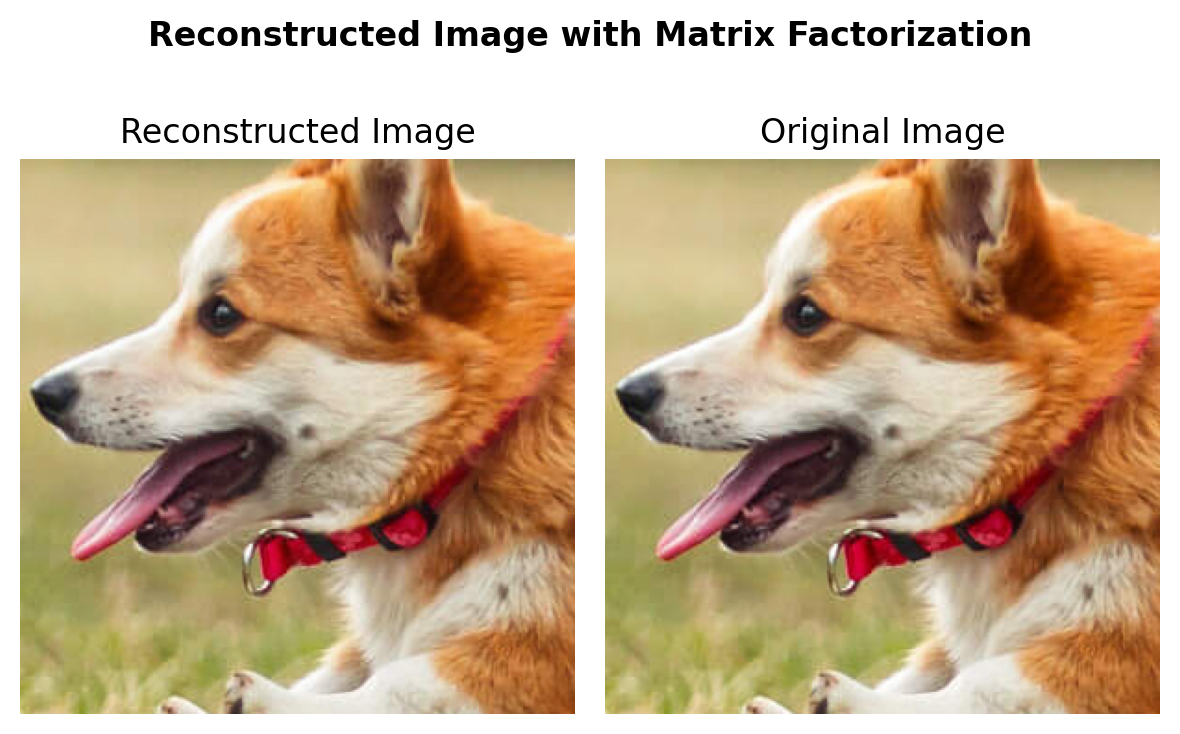

In [12]:
reconstruct_img = reconstruction(crop, 150)

In [13]:
def calculate_metrics(original, predicted):
    # Ensure both images are on the same scale
    original = original.float()
    predicted = predicted.float()
    diff = original - predicted
    mse = torch.mean(diff ** 2)

    # RMSE
    rmse = torch.sqrt(mse)
    print(f"RMSE: {rmse.item()}")

    # PSNR
    max_pixel_value = 255.0  
    psnr = 20 * torch.log10(max_pixel_value / torch.sqrt(mse))
    print(f"PSNR: {psnr.item()} dB")

In [14]:
calculate_metrics(crop.cpu(), reconstruct_img.cpu())

RMSE: 1.318026065826416
PSNR: 45.732322692871094 dB


# Question 2

## Using Matrix Factorization

In [15]:
def mask_image_rgb(img, prop):
    """
    img: torch.Tensor of shape (3, height, width) with dtype uint8 representing an RGB image
    prop: float representing the proportion of pixels to mask with NaN

    return: masked image and the mask
    """
    # Convert to float32 for processing, as NaN values can't be used with uint8
    img_float = img.clone().float()

    # Create a mask for a single channel (height, width), then expand it to 3 channels
    mask = torch.rand(img.shape[1], img.shape[2]) < prop  # Random mask for each pixel
    mask = mask.unsqueeze(0).expand_as(img)  # Expand mask to have 3 channels

    # Apply mask to all RGB channels
    img_float[mask] = float('nan')

    return img_float, mask


In [16]:
def mask_image_rgb_exact(img, num_pixels):
    """
    img: torch.Tensor of shape (3, height, width) with dtype uint8 representing an RGB image
    num_pixels: int representing the exact number of pixels to mask with NaN

    return: masked image and the mask
    """
    # Convert to float32 for processing, as NaN values can't be used with uint8
    img_float = img.clone().float()

    # Get height and width of the image
    _, height, width = img.shape

    # Total number of pixels in the image
    total_pixels = height * width

    if num_pixels > total_pixels:
        raise ValueError("Number of pixels to mask exceeds the total number of pixels in the image.")

    # Generate a 1D array of indices representing all pixel positions
    pixel_indices = torch.randperm(total_pixels)[:num_pixels]  # Randomly select `num_pixels` indices

    # Convert the indices to (row, col) coordinates
    row_indices = pixel_indices // width
    col_indices = pixel_indices % width

    # Create a mask initialized to False
    mask = torch.zeros(height, width, dtype=torch.bool)

    # Set the selected pixel positions to True in the mask
    mask[row_indices, col_indices] = True

    # Expand the mask to have 3 channels (for RGB)
    mask = mask.unsqueeze(0).expand_as(img_float)

    # Apply mask to the image
    img_float[mask] = float('nan')

    return img_float, mask


In [17]:
def plot_masked_image(masked_img):
    # Replace NaN with zero for display purposes (or you can use another value)
    img_display = masked_img.clone()
    img_display[torch.isnan(img_display)] = 0  # Replace NaN with black (0)

    # Convert back to uint8 for display
    img_display = img_display.clamp(0, 255).uint8()

    # Plotting
    img_display = img_display.permute(1, 2, 0)  # Convert from (3, H, W) to (H, W, 3)
    plt.imshow(img_display.numpy())
    plt.axis('off')  # Hide axes
    plt.show()

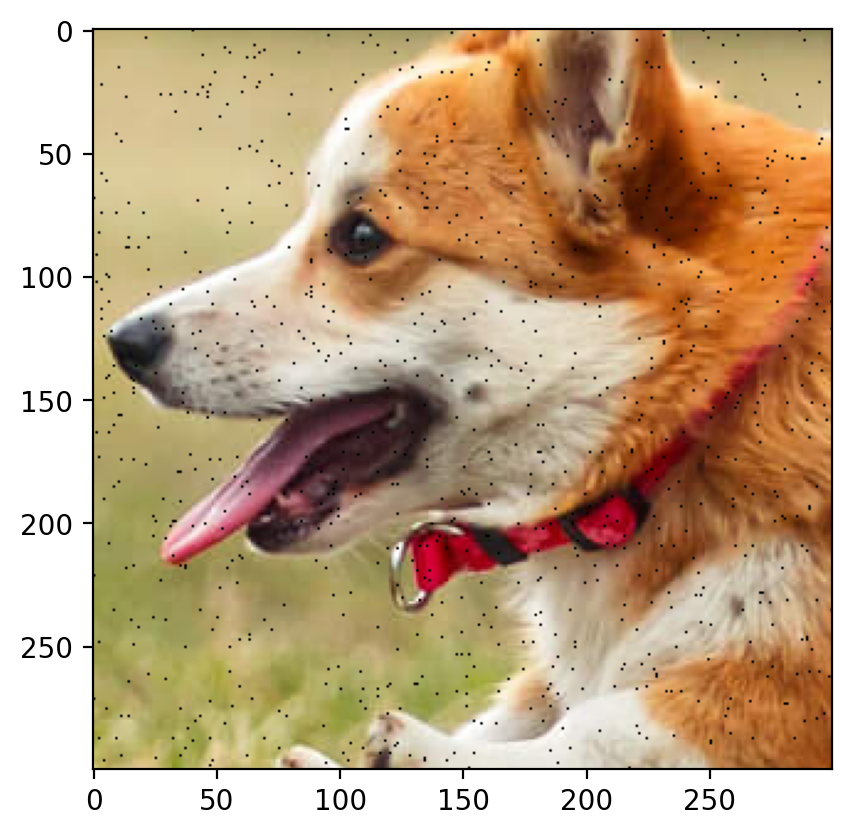

In [18]:
masked_img, mask = mask_image_rgb(crop, 0.01)
masked_img_int = int_convertor(masked_img)
plt.imshow(rearrange(masked_img_int, 'c h w -> h w c'))

In [19]:
# Mask the image with NaN values
def mask_image(img, prop):
    img_copy = img.clone().float()
    mask = torch.rand(img.shape) < prop
    img_copy[mask] = float('nan')
    return img_copy, mask

In [20]:
def image_reconstruction(image, k, prop):
    image_2d = image.reshape(-1, image.size(-1))
    masked_img, mask = mask_image(image_2d, prop)
    W, H, loss = factorize(masked_img, k)
    reconstructed_image = torch.mm(W, H)
    reconstructed_image_3D = reconstructed_image.reshape(3, image.shape[1], -1)
    reconstructed_image_3D_updated = int_convertor(reconstructed_image_3D)
    plot_reconstructed_image(reconstructed_image_3D_updated, image)
    return reconstructed_image_3D_updated

In [21]:
def calculate_metrics(original, predicted):
    # Ensure both images are on the same scale
    original = original.float()
    predicted = predicted.float()
    diff = original - predicted
    mse = torch.mean(diff ** 2)

    # RMSE
    rmse = torch.sqrt(mse)
    print(f"RMSE: {rmse.item()}")

    # PSNR
    max_pixel_value = 255.0  # Since the images are normalized between 0 and 1
    psnr = 20 * torch.log10(max_pixel_value / torch.sqrt(mse))
    print(f"PSNR: {psnr.item()} dB")

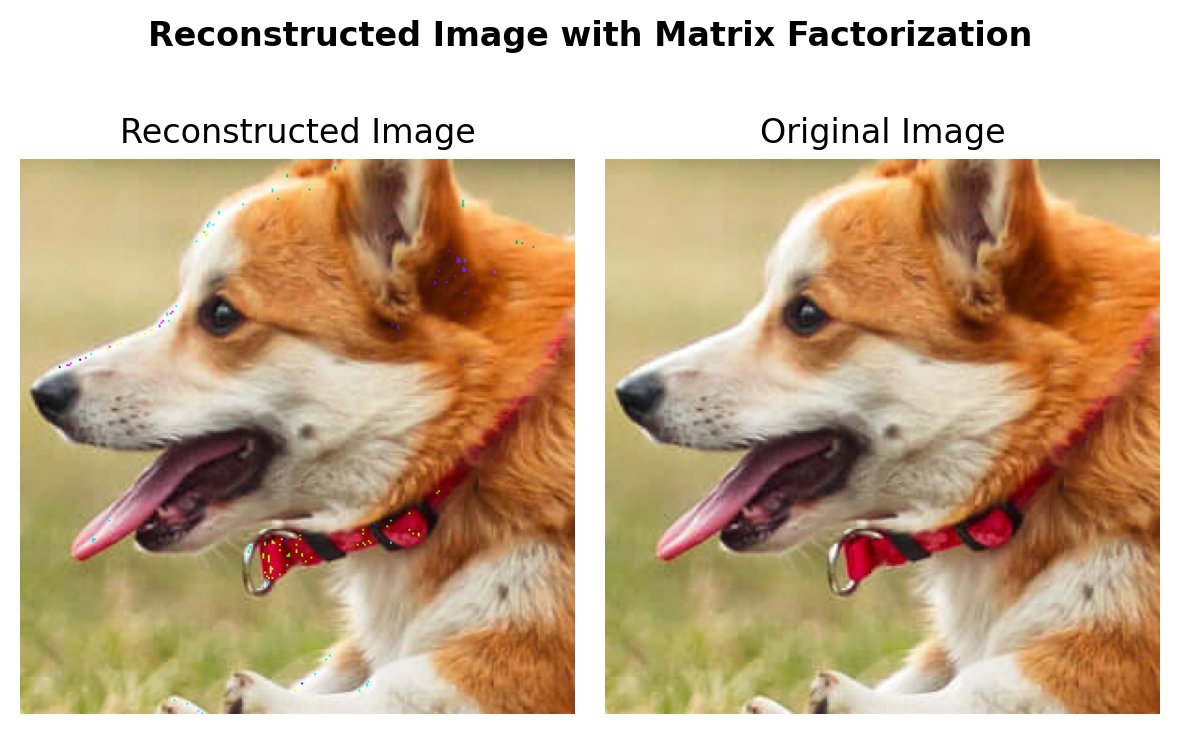

In [22]:
reconstructed_img = image_reconstruction(crop, 150, 0.01)

In [23]:
calculate_metrics(crop.cpu(), reconstructed_img.cpu())

RMSE: 6.43524694442749
PSNR: 31.95949935913086 dB


## Using RFF + Linear Regression

In [24]:
# Image completion
import os
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

# Read in a image from torchvision
import torchvision
img = torchvision.io.read_image("dog.jpg")

print(img.shape)

dog.jpg exists
torch.Size([3, 1365, 2048])


In [25]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img

MinMaxScaler()

In [26]:
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled.shape

img_scaled = torch.tensor(img_scaled)

In [27]:
img_scaled = img_scaled.to(device)
img_scaled.shape

torch.Size([3, 1365, 2048])

In [28]:
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 600, 800, 300, 300)
crop.shape

torch.Size([3, 300, 300])

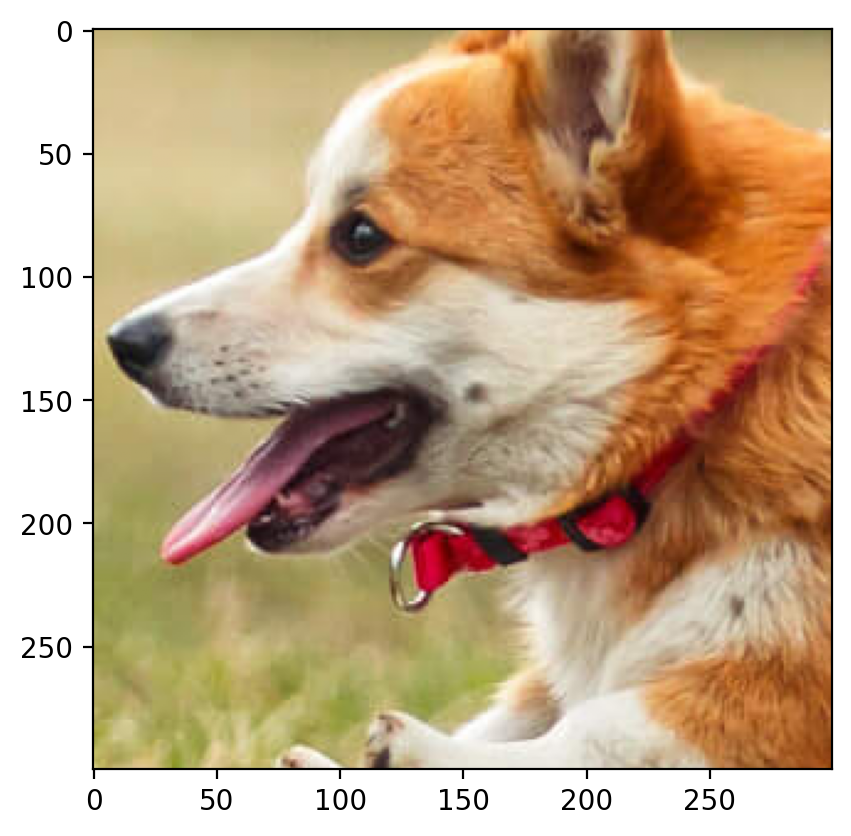

In [29]:
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())
crop = crop.to(device)

In [30]:
crop = crop.to(device)
crop = torch.tensor(crop, dtype=torch.float32)

In [31]:
import random

def mask_imageL(image, n):
    image = image.clone()
    # Convert image to tensor if it's not already
    if not torch.is_tensor(image):
        image = torch.tensor(image)

    # Get image dimensions
    num_channels, height, width = image.shape

    # Flatten image tensor
    flat_image = image.reshape(num_channels, -1)

    # Generate random indices for n pixels
    indices = random.sample(range(height * width), n)

    # Set values at selected indices to NaN for each channel
    for channel in range(num_channels):
        flat_image[channel][indices] = float('nan')

    # Reshape the flattened tensor to original shape
    image_with_nans = flat_image.reshape(num_channels, height, width)

    return image_with_nans, indices

In [32]:
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape

    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [33]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)


In [34]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)


        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

In [35]:
# create RFF features
def create_rff_features(X, num_features, sigma):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2), random_state=42)
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)


In [36]:
def plot_reconstructed_and_original_image(original_img, net, X, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)
        #outputs = outputs.permute(1, 2, 0)
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")


    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")

    for a in [ax0, ax1]:
        a.axis("off")


    fig.suptitle(title, y=0.9)
    plt.tight_layout()
    return outputs.cpu()

In [37]:
n = int(30 * 30)  # Number of random pixels to change to NaN

masked_image, indices = mask_imageL(crop, n)

In [38]:
masked_image

tensor([[[0.7686, 0.7686, 0.7686,  ..., 0.5451, 0.5451, 0.5412],
         [0.7725, 0.7725, 0.7725,  ..., 0.5686, 0.5686, 0.5647],
         [0.7765, 0.7765, 0.7765,  ..., 0.5882, 0.5843, 0.5843],
         ...,
         [0.7961, 0.7373, 0.7176,  ..., 0.5843, 0.5725, 0.5490],
         [0.8471, 0.7843, 0.7451,  ..., 0.6039, 0.5686, 0.5569],
         [0.8784, 0.8196, 0.7686,  ..., 0.6275, 0.5804, 0.5686]],

        [[0.6941, 0.6941, 0.6941,  ..., 0.5137, 0.5137, 0.5098],
         [0.6980, 0.6980, 0.6980,  ..., 0.5255, 0.5255, 0.5216],
         [0.7020, 0.7020, 0.7020,  ..., 0.5451, 0.5412, 0.5412],
         ...,
         [0.7686, 0.7098, 0.6863,  ..., 0.2824, 0.2706, 0.2431],
         [0.8157, 0.7569, 0.7137,  ..., 0.3059, 0.2667, 0.2431],
         [0.8431, 0.7882, 0.7333,  ..., 0.3294, 0.2706, 0.2588]],

        [[0.4745, 0.4745, 0.4745,  ..., 0.3294, 0.3294, 0.3255],
         [0.4784, 0.4784, 0.4784,  ..., 0.3451, 0.3451, 0.3412],
         [0.4824, 0.4824, 0.4824,  ..., 0.3647, 0.3608, 0.

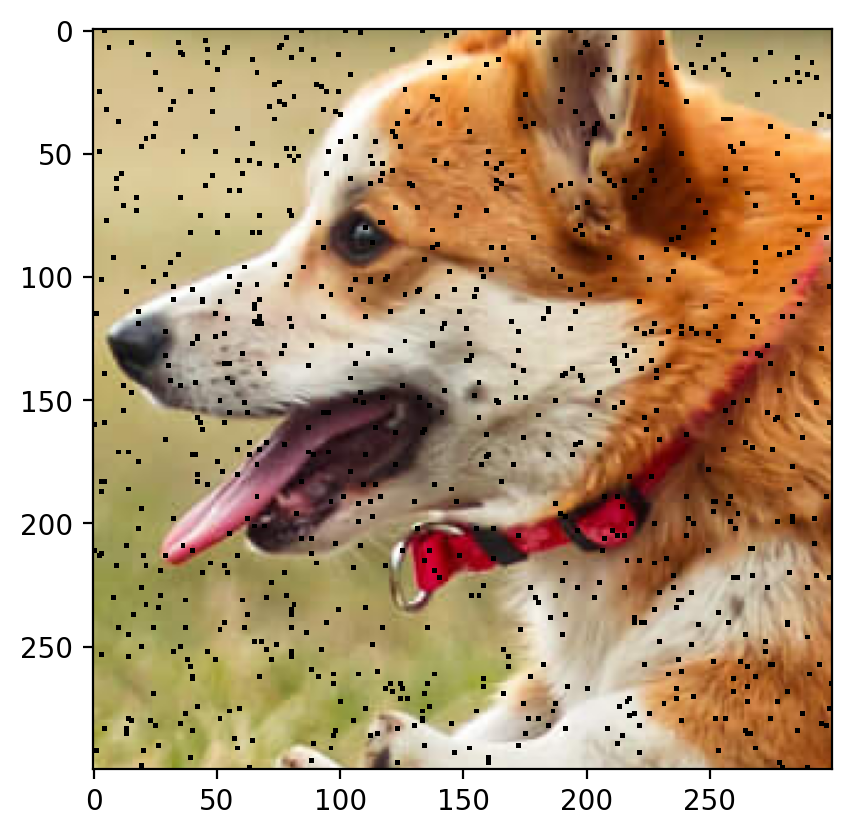

In [39]:
plt.imshow(rearrange(masked_image, 'c h w -> h w c').cpu().numpy())

In [40]:
dog_X,dog_Y=create_coordinate_map(masked_image)

nan_count = torch.isnan(dog_Y).sum().item()

# Print the result
print("Number of NaN values:", nan_count)

dog_Xnew = np.delete(dog_X.cpu(),indices,axis=0)
dog_Ynew = np.delete(dog_Y.cpu(),indices,axis=0)

scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog_Xnew.cpu())
# Scale the X coordinates
dog_X_scaled = scaler_X.transform(dog_Xnew.cpu())

# Move the scaled X coordinates to the GPU
dog_X_scaled = torch.tensor(dog_X_scaled).to(device)

# Set to dtype float32
dog_X_scaled = dog_X_scaled.float()
# dog_X, dog_X_scaled

Number of NaN values: 2700


In [41]:
dog_Ynew = dog_Ynew.to(device)

In [42]:
X_rff = create_rff_features(dog_X_scaled, 10000, 0.008)
X_rff = X_rff.to(device)

In [43]:
net = LinearModel(X_rff.shape[1], 3)
net.to(device)

train(net, 0.005, X_rff, dog_Ynew, 1000)

Epoch 0 loss: 0.370617
Epoch 100 loss: 0.060280
Epoch 200 loss: 0.021109
Epoch 300 loss: 0.015405
Epoch 400 loss: 0.012803
Epoch 500 loss: 0.011031
Epoch 600 loss: 0.009721
Epoch 700 loss: 0.008715
Epoch 800 loss: 0.007921
Epoch 900 loss: 0.007286


0.006775219459086657

In [44]:
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog_X.cpu())

# Scale the X coordinates
dog_X_scaledp = scaler_X.transform(dog_X.cpu())

# Move the scaled X coordinates to the GPU
dog_X_scaledp = torch.tensor(dog_X_scaledp).to(device)

# Set to dtype float32
dog_X_scaledp = dog_X_scaledp.float()

In [45]:
X_rffp = create_rff_features(dog_X_scaledp, 10000, 0.008)
X_rffp.shape

torch.Size([90000, 10000])

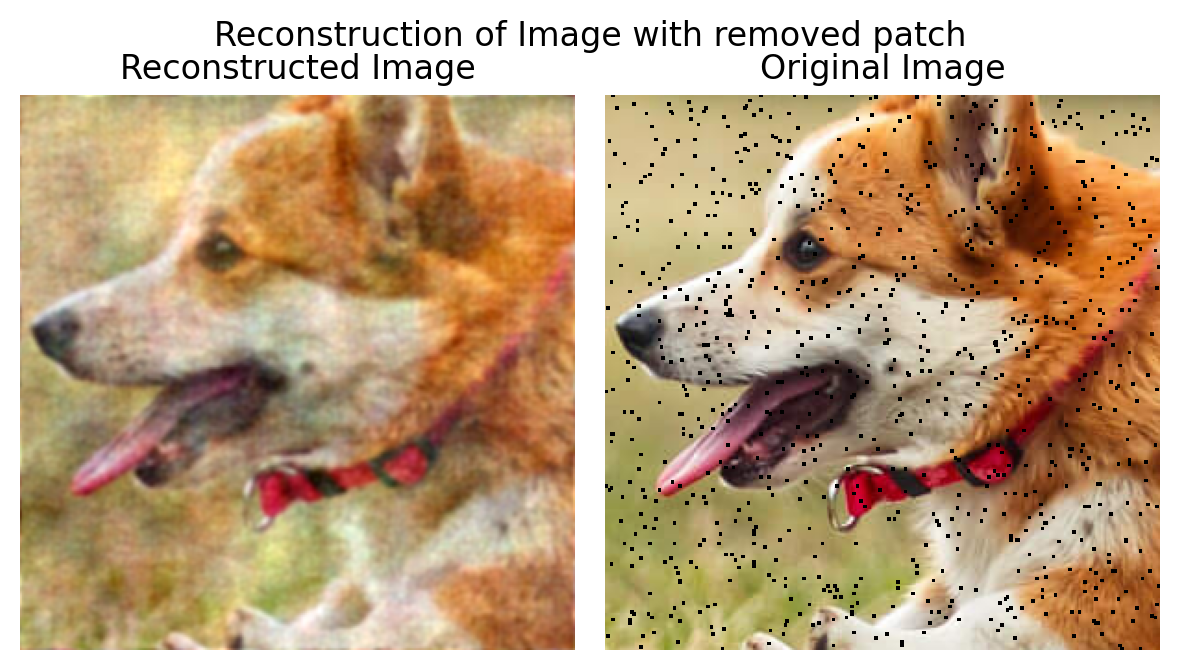

In [46]:
pred_img = plot_reconstructed_and_original_image(masked_image, net, X_rffp, title="Reconstruction of Image with removed patch")

In [47]:
def calculate_metrics(original, predicted):
    # Ensure both images are on the same scale
    original = original.float()
    predicted = predicted.float()
    diff = original - predicted
    mse = torch.mean(diff ** 2)

    # RMSE
    rmse = torch.sqrt(mse)
    print(f"RMSE: {rmse.item()}")

    # PSNR
    max_pixel_value = 1.0  # Since the images are normalized between 0 and 1
    psnr = 20 * torch.log10(max_pixel_value / torch.sqrt(mse))
    print(f"PSNR: {psnr.item()} dB")
calculate_metrics(rearrange(crop, 'c h w -> h w c').cpu(), pred_img)

RMSE: 0.08236518502235413
PSNR: 21.68512535095215 dB


comparing metric values, we can see that RFF method is giving us better results